In [1]:
import os
import re
import ast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from glob import glob
from scipy.stats import ttest_1samp
import scikit_posthocs as sp
from typing import defaultdict

In [2]:
# Step 1: Load all dictionaries from markdown files
results = []

for filepath in glob("*.md"):
    model_name = os.path.splitext(os.path.basename(filepath))[0]
    with open(filepath, "r") as f:
        content = f.read()
    dicts = re.findall(r"results_dict\s*=\s*({.*?})", content, re.DOTALL)
    for d in dicts:
        parsed = ast.literal_eval(d)
        for benchmark, score in parsed.items():
            results.append({
                "model": model_name,
                "benchmark": benchmark,
                "score": score
            })

df = pd.DataFrame(results)

In [3]:
df["benchmark"] = df["benchmark"].map(lambda s: s.split("_")[0].replace("CHEMBL", ""))

In [4]:
win_tracker = defaultdict(int)

n_benchmarks = len(df["benchmark"].unique())

for i, (model, model_df) in enumerate(df.groupby("model", sort=False)):
    for j, (benchmark, bench_df) in enumerate(model_df.groupby("benchmark", sort=False)):
        result = ttest_1samp(bench_df["score"], 0.0, alternative="greater")
        # print(bench_df["score"].mean(), bench_df["score"].std())
        if result.pvalue < 0.05:
            # print("reject - worse")
            ...  # mean is practically less than zero
        else:
            # print("accept - better")
            win_tracker[model] += 1

results = pd.DataFrame.from_records(
    [{
        "model": model.replace("_", " "),
        "win count": win_count,
        "win rate (%)": 100 * win_count / n_benchmarks,
    } for model, win_count in win_tracker.items()
    ], index="model").sort_values(by="win rate (%)", axis=0, ascending=False)
results.round(1)


,win count,win rate (%)
model,,
MoLFormer,3,10.3


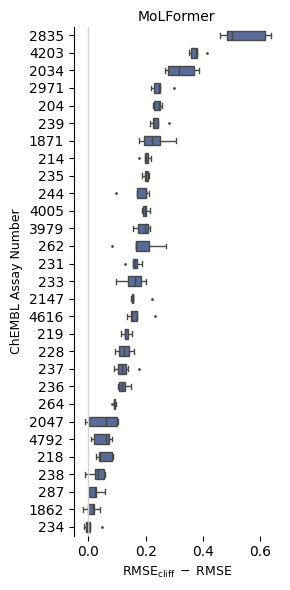

In [6]:
order = (df.groupby("benchmark")["score"]
           .median()
           .sort_values(ascending=False)
           .index)

# 2) prepare the figure grid: one column per model
models = sorted(df["model"].unique())
n_models = len(models)
fig, axes = plt.subplots(nrows=1, ncols=n_models,
                         figsize=(3*n_models, 6),  # 3 in wide per model
                         sharey=True)

if n_models == 1:   # when there’s only one model, axes isn’t a list
    axes = [axes]

# 3) plot each model in its own column
for ax, mod in zip(axes, models):
    sub = df[df["model"] == mod]
    sns.boxplot(data=sub,
                y="benchmark", x="score",
                order=order,
                color="#4f67a0",
                width=0.55, fliersize=1,
                ax=ax)
    ax.axvline(0, color="lightgrey", lw=1)
    ax.set_title(mod, fontsize=10, pad=4)
    ax.set_xlabel(r"$\mathrm{RMSE_{cliff}\;-\;RMSE}$", fontsize=9)
    # hide y‑labels on all but the first column
    if ax is not axes[0]:
        ax.set_ylabel("")
        ax.tick_params(axis='y', length=0)
    else:
        ax.set_ylabel("ChEMBL Assay Number", fontsize=9)
    sns.despine(ax=ax, left=ax is not axes[0], bottom=True)

plt.tight_layout(w_pad=2)      # little horizontal padding between columns
plt.show()